In this notebook, Ant and Bee images were used for classification.

This note was inspired by "TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL ".

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


In [1]:
pip install dezero

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import dezero
import dezero.functions as F
import dezero.layers as L
from dezero import DataLoader, optimizers, Parameter
from dezero.models import VGG16

In [4]:
#Change to the path where the image files are saved.
path = "./drive/MyDrive/ColabNotebooks/hymenoptera_data/"

train_path_ants = glob.glob(path + "train/ants/*")
train_path_bees = glob.glob(path + "train/bees/*")

test_path_ants = glob.glob(path + "val/ants/*")
test_path_bees = glob.glob(path + "val/bees/*")

train_path, test_path = [], []
train_path.extend(train_path_ants)
train_path.extend(train_path_bees)

test_path.extend(test_path_ants)
test_path.extend(test_path_bees)

#Create target labels. Ants are 0 and Bees are 1.
train_label = np.append(np.zeros(len(train_path_ants)),
                        np.ones(len(train_path_bees)))
test_label = np.append(np.zeros(len(test_path_ants)),
                        np.ones(len(test_path_bees)))

Make Dasetset for Dataloader

In [5]:
class MyDataset:
  def __init__(self, path, label, transform):
    self.path = path
    self.label = label
    self.transform = transform

  def __getitem__(self, index):
    img = Image.open(self.path[index])
    img = self.transform(img)
    return img, int(self.label[index])

  def __len__(self):
    return len(self.label)

In [6]:
batchsize = 8
train_set = MyDataset(train_path, train_label, VGG16.preprocess)
train_loader = DataLoader(train_set, batchsize, shuffle=True)

test_set = MyDataset(test_path, test_label, VGG16.preprocess)
test_loader = DataLoader(test_set, batchsize, shuffle=False)

train_loader.to_gpu()
test_loader.to_gpu()

"class FreezeParam" in dezero/optimizers.py was slightly changed.

In [7]:
class FreezeParam:
    def __init__(self, *layers):
        self.freeze_params = []
        for l in layers:
            if isinstance(l, Parameter):
                self.freeze_params.append(l)
            else:
                for p in l.params():
                    self.freeze_params.append(p)

    def __call__(self, params):
        for p in self.freeze_params:
            p.grad.data = 0.

VGG16 was pretrained.

Convolutional Layers were freezed and Fully Connected layers ware trained.

In [8]:
net = VGG16(pretrained=True)
net.fc8 = L.Linear(2)  #replace output layer.
freeze_layers = [net.conv1_1, net.conv1_2, net.conv2_1, net.conv2_2,
                 net.conv3_1, net.conv3_2, net.conv3_3,
                 net.conv4_1, net.conv4_2, net.conv4_3,
                 net.conv5_1, net.conv5_2, net.conv5_3]
freeze_fn = FreezeParam(*freeze_layers)

optimizer = optimizers.AdaGrad(lr=0.001).setup(net)
optimizer.add_hook(freeze_fn)

net.to_gpu()

In [9]:
def test_score(net, test_loader, test_set):
  """
  return test_loss and accurcy, test_mode
  """
  #initialize tmp_loss and tmp accuracy for test_loader.
  tmp_loss, tmp_acc = 0.0, 0.0
  
  for x, y in test_loader:
    y_pred = net(x)
    loss = F.softmax_cross_entropy(y_pred, y)
    tmp_loss += float(loss.data) * len(y)
    tmp_acc += float(F.accuracy(y_pred, y).data) * len(y)

  return tmp_loss / (len(test_set)), tmp_acc / len(test_set)

In [10]:
def train_net(net, train_loader, test_loader, max_epoch=1):
  #lists to record the training progresses.
  train_losses, test_losses = [], []
  train_accuracies, test_accuracies = [], []
  
  for epoch in range(max_epoch):
    #Initialize the tmp_loss and the tmp_accuracy
    tmp_loss, tmp_acc = 0.0, 0.0
    for x, y in train_loader:
      y_pred = net(x)
      loss = F.softmax_cross_entropy(y_pred, y)

      net.cleargrads()
      loss.backward()
      optimizer.update()

      tmp_loss += float(loss.data) * len(y)
      tmp_acc += float(F.accuracy(y_pred, y).data) * len(y)

    #record train loss and train accuracies 
    train_losses.append(tmp_loss / (len(train_set)))
    train_accuracies.append(tmp_acc / len(train_set))

    #calculate_test
    test_loss, test_acc = test_score(net, test_loader, test_set)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print("Epoch:", epoch + 1)
    print("train_loss:{:.3f},'test loss: {:.3f}".format(
        train_losses[-1], test_losses[-1]))
    print("train_acc:{:.3f},'test acc: {:.3f}".format(
        train_accuracies[-1], test_accuracies[-1]))

  return net, [train_losses, test_losses, train_accuracies, test_accuracies]

In [11]:
max_epoch = 10
net, progress = train_net(net, train_loader, test_loader, max_epoch)

Epoch: 1
train_loss:6.604,'test loss: 0.710
train_acc:0.754,'test acc: 0.908
Epoch: 2
train_loss:0.150,'test loss: 1.026
train_acc:0.967,'test acc: 0.902
Epoch: 3
train_loss:0.032,'test loss: 1.208
train_acc:0.992,'test acc: 0.908
Epoch: 4
train_loss:0.000,'test loss: 1.010
train_acc:1.000,'test acc: 0.915
Epoch: 5
train_loss:0.002,'test loss: 0.938
train_acc:1.000,'test acc: 0.922
Epoch: 6
train_loss:0.000,'test loss: 1.268
train_acc:1.000,'test acc: 0.922
Epoch: 7
train_loss:0.002,'test loss: 1.438
train_acc:1.000,'test acc: 0.908
Epoch: 8
train_loss:0.000,'test loss: 1.060
train_acc:1.000,'test acc: 0.922
Epoch: 9
train_loss:0.000,'test loss: 1.133
train_acc:1.000,'test acc: 0.922
Epoch: 10
train_loss:0.000,'test loss: 1.376
train_acc:1.000,'test acc: 0.902


<br><br>
Visualize the results

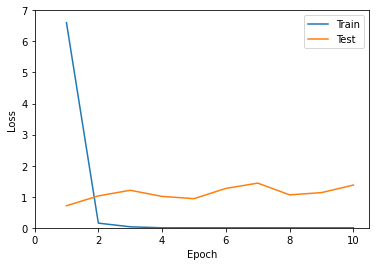

In [12]:
plt.plot(np.arange(max_epoch) + 1, progress[0], label="Train")
plt.plot(np.arange(max_epoch) + 1, progress[1], label="Test")
plt.xlim(0, max_epoch + 0.5)
plt.ylim(0, 7)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc=1)
plt.show()

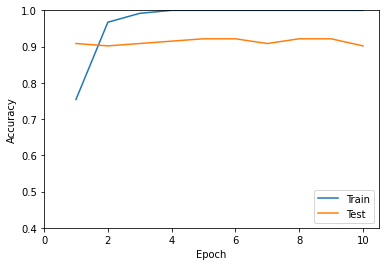

In [13]:
plt.plot(np.arange(max_epoch) + 1, progress[2], label="Train")
plt.plot(np.arange(max_epoch) + 1, progress[3], label="Test")
plt.xlim(0, max_epoch + 0.5)
plt.ylim(0.4, 1)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc=4)
plt.show()

<br><br>
### **The case All Layers were trained is below.**

In [14]:
#Initialize the network
net_no_freeze = VGG16(pretrained=True)
net_no_freeze.fc8 = L.Linear(2)  #replace output layer. 
optimizer = optimizers.AdaGrad(lr=0.001).setup(net_no_freeze)
net_no_freeze.to_gpu()
net_no_freeze, progress_no_freeze = train_net(net_no_freeze,
                                              train_loader, test_loader,
                                              max_epoch)

Epoch: 1
train_loss:43.478,'test loss: 1.802
train_acc:0.533,'test acc: 0.458
Epoch: 2
train_loss:1.156,'test loss: 0.765
train_acc:0.459,'test acc: 0.490
Epoch: 3
train_loss:0.862,'test loss: 0.946
train_acc:0.549,'test acc: 0.556
Epoch: 4
train_loss:0.764,'test loss: 0.653
train_acc:0.582,'test acc: 0.621
Epoch: 5
train_loss:0.777,'test loss: 1.749
train_acc:0.578,'test acc: 0.458
Epoch: 6
train_loss:0.754,'test loss: 0.848
train_acc:0.619,'test acc: 0.582
Epoch: 7
train_loss:0.678,'test loss: 0.673
train_acc:0.643,'test acc: 0.673
Epoch: 8
train_loss:0.656,'test loss: 0.679
train_acc:0.672,'test acc: 0.660
Epoch: 9
train_loss:0.624,'test loss: 0.700
train_acc:0.660,'test acc: 0.693
Epoch: 10
train_loss:0.536,'test loss: 0.746
train_acc:0.742,'test acc: 0.686


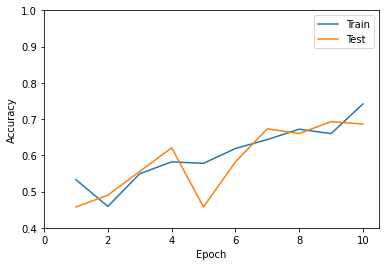

In [15]:
plt.plot(np.arange(max_epoch) + 1, progress_no_freeze[2], label="Train")
plt.plot(np.arange(max_epoch) + 1, progress_no_freeze[3], label="Test")
plt.xlim(0, max_epoch + 0.5)
plt.ylim(0.4, 1)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc=1)
plt.show()